# Solar

In [1]:
# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sqlite3

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Cell 2: Define the Dataset class for energy data
class EnergyDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = features
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

In [3]:
# Cell 3: Define the CNN model architecture
class EnergyCNN(nn.Module):
    def __init__(self, input_channels, sequence_length):
        super(EnergyCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=input_channels,
                              out_channels=32,
                              kernel_size=3,
                              padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=32,
                              out_channels=64,
                              kernel_size=3,
                              padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Calculate size after convolutions and pooling
        self.flatten_size = 64 * (sequence_length // 4)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, features)
        # Reshape for CNN: (batch_size, features, sequence_length)
        x = x.transpose(1, 2)

        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Flatten and fully connected layers
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [4]:
# Cell 4: Data loading and preprocessing functions
def load_energy_data(energy_type='solar'):
    conn = sqlite3.connect("energy_data_NE.db")

    # Load weather data
    weather_query = """
    SELECT time, temperature, dwpt, humidity, precipitation,
           wdir, windspeed, pres, cloudcover
    FROM historical_weather_data
    """
    weather_data = pd.read_sql_query(weather_query, conn)

    # Load energy data based on type
    if energy_type == 'solar':
        energy_query = "SELECT datetime, value FROM SUN_data_NE"
    elif energy_type == 'wind':
        energy_query = "SELECT datetime, value FROM WND_data_NE"
    else:  # demand
        energy_query = "SELECT datetime, Demand as value FROM demand_data_NE"

    energy_data = pd.read_sql_query(energy_query, conn)
    conn.close()

    # Prepare and clean data
    weather_data = weather_data.rename(columns={'time': 'datetime'})
    weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
    energy_data['datetime'] = pd.to_datetime(energy_data['datetime'])

    # Add temporal features
    weather_data['hour'] = weather_data['datetime'].dt.hour
    weather_data['month'] = weather_data['datetime'].dt.month
    weather_data['season'] = np.where(weather_data['datetime'].dt.month.isin([12, 1, 2]), 1,
                                     np.where(weather_data['datetime'].dt.month.isin([3, 4, 5]), 2,
                                             np.where(weather_data['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))

    # Merge data
    merged_data = pd.merge(weather_data, energy_data, on='datetime', how='inner')

    return merged_data

def prepare_data(merged_data, sequence_length=24):
    # Prepare features and target
    features = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation',
                           'wdir', 'windspeed', 'pres', 'cloudcover',
                           'hour', 'month', 'season']].values
    targets = merged_data[['value']].values

    # Scale data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    targets_scaled = scaler_target.fit_transform(targets)

    return features_scaled, targets_scaled, scaler_features, scaler_target

In [5]:
# Cell 5: Model training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return losses

def evaluate_model(model, test_loader, scaler_target, device):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    return predictions, actuals, mae, rmse, r2

Epoch 1/20, Loss: 0.0169
Epoch 2/20, Loss: 0.0097
Epoch 3/20, Loss: 0.0088
Epoch 4/20, Loss: 0.0082
Epoch 5/20, Loss: 0.0073
Epoch 6/20, Loss: 0.0074
Epoch 7/20, Loss: 0.0068
Epoch 8/20, Loss: 0.0068
Epoch 9/20, Loss: 0.0067
Epoch 10/20, Loss: 0.0062
Epoch 11/20, Loss: 0.0061
Epoch 12/20, Loss: 0.0058
Epoch 13/20, Loss: 0.0057
Epoch 14/20, Loss: 0.0057
Epoch 15/20, Loss: 0.0054
Epoch 16/20, Loss: 0.0055
Epoch 17/20, Loss: 0.0050
Epoch 18/20, Loss: 0.0049
Epoch 19/20, Loss: 0.0051
Epoch 20/20, Loss: 0.0048


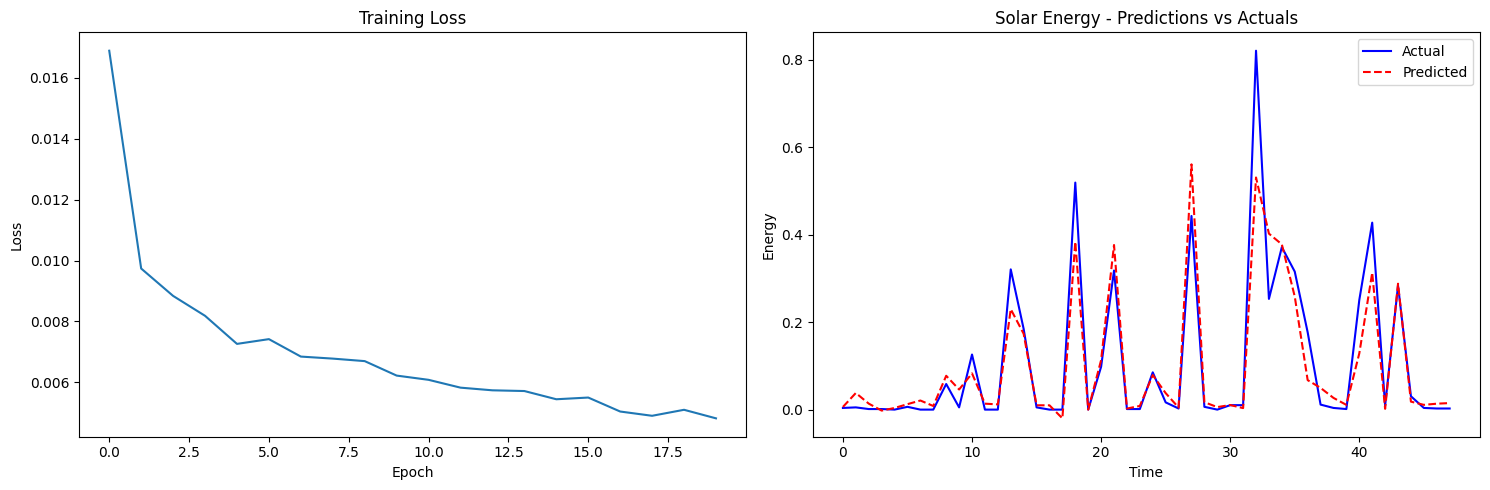


Metrics for solar energy prediction (computed on full test set):
MAE: 0.04
RMSE: 0.07
R²: 0.92


In [8]:
# Cell 6: Main execution
# Set hyperparameters
ENERGY_TYPE = 'solar'  # Options: 'solar', 'wind', 'demand'
BATCH_SIZE = 32
SEQUENCE_LENGTH = 24
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Load and prepare data
merged_data = load_energy_data(ENERGY_TYPE)
features_scaled, targets_scaled, scaler_features, scaler_target = prepare_data(merged_data, SEQUENCE_LENGTH)

# Create dataset
dataset = EnergyDataset(features_scaled, targets_scaled, SEQUENCE_LENGTH)

# Split data
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
input_channels = features_scaled.shape[1]
model = EnergyCNN(input_channels, SEQUENCE_LENGTH).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train model
losses = train_model(model, train_loader, criterion, optimizer, device, NUM_EPOCHS)

# Evaluate model (get all predictions first)
model.eval()
all_predictions = []
all_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_predictions.extend(outputs.cpu().numpy())
        all_actuals.extend(batch_y.numpy())

# Convert to arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Calculate metrics using all data
mae = mean_absolute_error(all_actuals, all_predictions)
rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
r2 = r2_score(all_actuals, all_predictions)

# Plot results
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Predictions vs Actuals (only first 48 samples for visualization)
plt.subplot(1, 2, 2)
plt.plot(all_actuals[:48], label='Actual', color='blue')
plt.plot(all_predictions[:48], label='Predicted', color='red', linestyle='--')
plt.title(f'{ENERGY_TYPE.capitalize()} Energy - Predictions vs Actuals')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nMetrics for {ENERGY_TYPE} energy prediction (computed on full test set):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Demand

In [9]:
# Cell 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sqlite3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Cell 2: Dataset Class for Demand Data
class DemandDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = features
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Test the dataset class
print("Dataset class defined successfully")

Dataset class defined successfully


In [11]:
# Cell 3: CNN Model for Demand Forecasting
class DemandCNN(nn.Module):
    def __init__(self, input_channels, sequence_length):
        super(DemandCNN, self).__init__()

        # First convolutional block with larger filters
        self.conv1 = nn.Conv1d(in_channels=input_channels,
                              out_channels=64,
                              kernel_size=5,
                              padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=64,
                              out_channels=128,
                              kernel_size=3,
                              padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Third convolutional block
        self.conv3 = nn.Conv1d(in_channels=128,
                              out_channels=256,
                              kernel_size=3,
                              padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Calculate size after convolutions and pooling
        self.flatten_size = 256 * (sequence_length // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Reshape for CNN
        x = x.transpose(1, 2)

        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Flatten and fully connected layers
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Print model summary (will be populated when model is instantiated)
print("Model class defined successfully")

Model class defined successfully


In [12]:
# Cell 4: Data Loading and Preprocessing Functions
def load_demand_data():
    conn = sqlite3.connect("energy_data_NE.db")

    # Load weather data
    weather_query = """
    SELECT time, temperature, dwpt, humidity, precipitation,
           wdir, windspeed, pres, cloudcover
    FROM historical_weather_data
    """
    weather_data = pd.read_sql_query(weather_query, conn)

    # Load demand data
    demand_query = "SELECT datetime, Demand as value FROM demand_data_NE"
    demand_data = pd.read_sql_query(demand_query, conn)

    conn.close()

    # Prepare and clean data
    weather_data = weather_data.rename(columns={'time': 'datetime'})
    weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
    demand_data['datetime'] = pd.to_datetime(demand_data['datetime'])

    # Add temporal features
    weather_data['hour'] = weather_data['datetime'].dt.hour
    weather_data['day_of_week'] = weather_data['datetime'].dt.dayofweek
    weather_data['month'] = weather_data['datetime'].dt.month
    weather_data['season'] = np.where(weather_data['datetime'].dt.month.isin([12, 1, 2]), 1,
                                     np.where(weather_data['datetime'].dt.month.isin([3, 4, 5]), 2,
                                             np.where(weather_data['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))

    # Add time-of-day feature
    weather_data['time_of_day'] = np.where(weather_data['hour'] < 6, 0,  # Night
                                          np.where(weather_data['hour'] < 12, 1,  # Morning
                                                  np.where(weather_data['hour'] < 18, 2, 3)))  # Afternoon, Evening

    # Merge data
    merged_data = pd.merge(weather_data, demand_data, on='datetime', how='inner')

    return merged_data

def prepare_demand_data(merged_data, sequence_length=24):
    # Prepare features
    features = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation',
                           'wdir', 'windspeed', 'pres', 'cloudcover',
                           'hour', 'day_of_week', 'month', 'season',
                           'time_of_day']].values
    targets = merged_data[['value']].values

    # Scale data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    targets_scaled = scaler_target.fit_transform(targets)

    return features_scaled, targets_scaled, scaler_features, scaler_target

# Load and prepare the data
merged_data = load_demand_data()
features_scaled, targets_scaled, scaler_features, scaler_target = prepare_demand_data(merged_data)

print("Data loaded successfully")
print(f"Features shape: {features_scaled.shape}")
print(f"Targets shape: {targets_scaled.shape}")

Data loaded successfully
Features shape: (17545, 13)
Targets shape: (17545, 1)


In [13]:
# Cell 5: Training and Evaluation Functions
def train_demand_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return losses

def evaluate_demand_model(model, test_loader, scaler_target, device):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    return predictions, actuals, mae, rmse, r2

print("Training and evaluation functions defined successfully")

Training and evaluation functions defined successfully


Epoch 1/30, Loss: 0.0149
Epoch 2/30, Loss: 0.0058
Epoch 3/30, Loss: 0.0049
Epoch 4/30, Loss: 0.0042
Epoch 5/30, Loss: 0.0035
Epoch 6/30, Loss: 0.0039
Epoch 7/30, Loss: 0.0030
Epoch 8/30, Loss: 0.0028
Epoch 9/30, Loss: 0.0026
Epoch 10/30, Loss: 0.0025
Epoch 11/30, Loss: 0.0022
Epoch 12/30, Loss: 0.0022
Epoch 13/30, Loss: 0.0020
Epoch 14/30, Loss: 0.0021
Epoch 15/30, Loss: 0.0019
Epoch 16/30, Loss: 0.0018
Epoch 17/30, Loss: 0.0018
Epoch 18/30, Loss: 0.0017
Epoch 19/30, Loss: 0.0017
Epoch 20/30, Loss: 0.0014
Epoch 21/30, Loss: 0.0015
Epoch 22/30, Loss: 0.0016
Epoch 23/30, Loss: 0.0014
Epoch 24/30, Loss: 0.0014
Epoch 25/30, Loss: 0.0013
Epoch 26/30, Loss: 0.0013
Epoch 27/30, Loss: 0.0014
Epoch 28/30, Loss: 0.0014
Epoch 29/30, Loss: 0.0012
Epoch 30/30, Loss: 0.0012


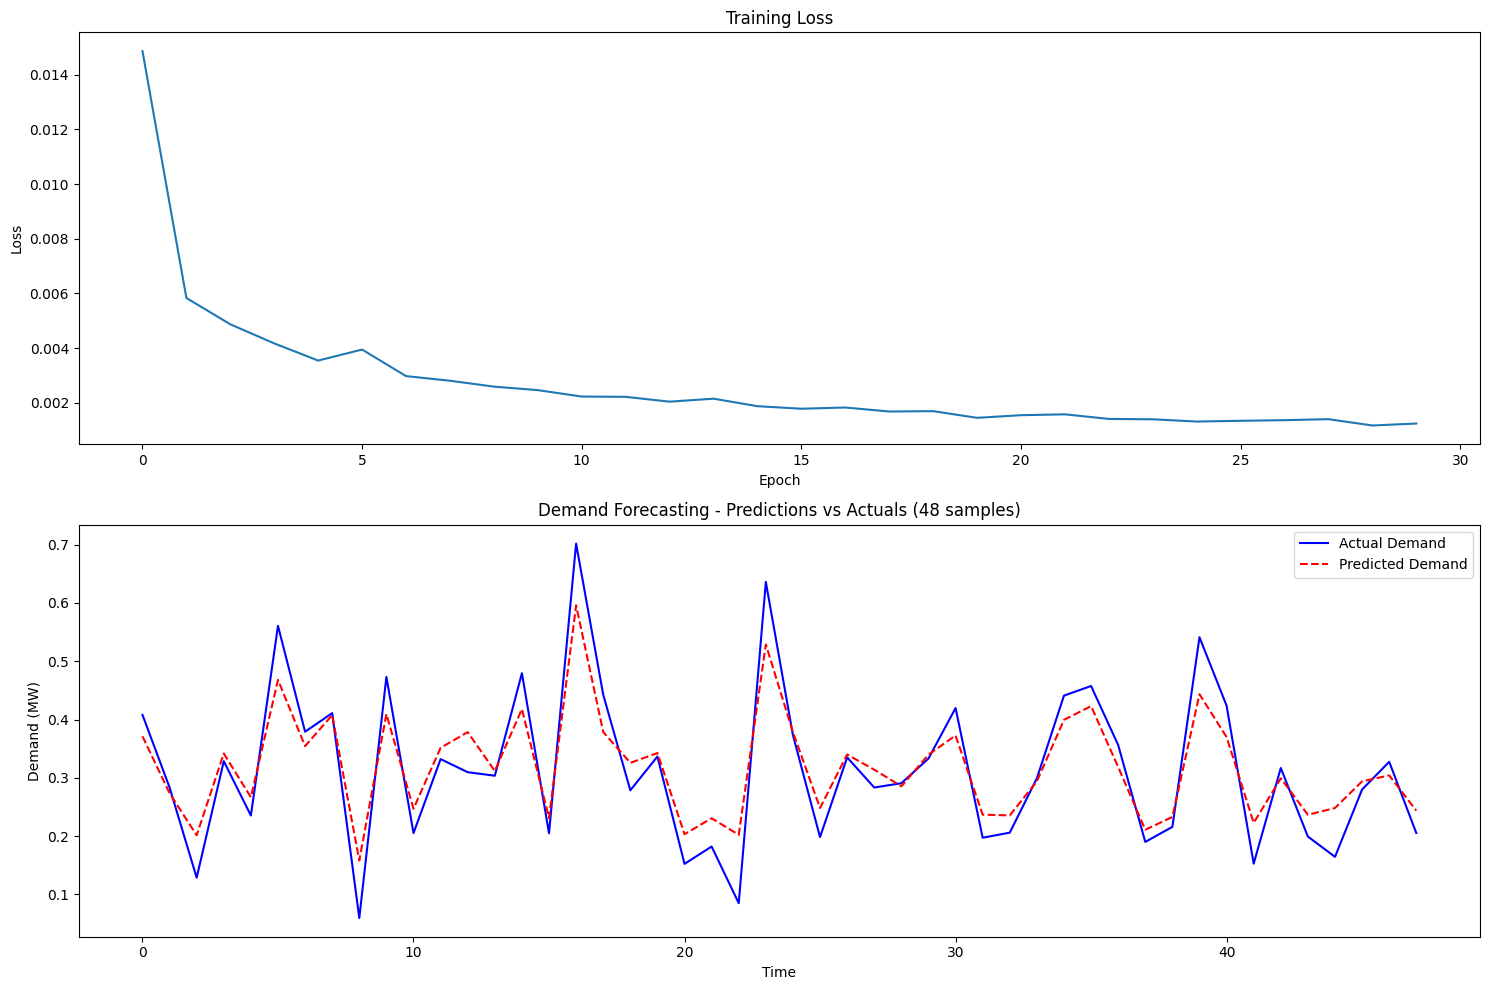


Demand Forecasting Metrics (computed on full test set):
MAE: 0.04 MW
RMSE: 0.05 MW
R²: 0.8682


In [14]:
# Cell 6: Main Execution
# Hyperparameters
BATCH_SIZE = 64
SEQUENCE_LENGTH = 48  # Two days of hourly data
NUM_EPOCHS = 30
LEARNING_RATE = 0.0005

# Create dataset
dataset = DemandDataset(features_scaled, targets_scaled, SEQUENCE_LENGTH)

# Split data
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
input_channels = features_scaled.shape[1]
model = DemandCNN(input_channels, SEQUENCE_LENGTH).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Train model
losses = train_demand_model(model, train_loader, criterion, optimizer, device, NUM_EPOCHS)

# Evaluate model (get all predictions first)
model.eval()
all_predictions = []
all_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_predictions.extend(outputs.cpu().numpy())
        all_actuals.extend(batch_y.numpy())

# Convert to arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Calculate metrics using all data
mae = mean_absolute_error(all_actuals, all_predictions)
rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
r2 = r2_score(all_actuals, all_predictions)

# Plot results
plt.figure(figsize=(15, 10))

# Training loss
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Predictions vs Actuals (only first 48 samples for visualization)
plt.subplot(2, 1, 2)
plt.plot(all_actuals[:48], label='Actual Demand', color='blue')
plt.plot(all_predictions[:48], label='Predicted Demand', color='red', linestyle='--')
plt.title('Demand Forecasting - Predictions vs Actuals (48 samples)')
plt.xlabel('Time')
plt.ylabel('Demand (MW)')
plt.legend()

plt.tight_layout()
plt.show()

print("\nDemand Forecasting Metrics (computed on full test set):")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")
print(f"R²: {r2:.4f}")

# Wind

In [15]:
# Cell 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sqlite3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [16]:
# Cell 2: Dataset Class for Wind Data
class WindDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = features
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

print("Dataset class defined successfully")

Dataset class defined successfully


In [17]:
# Cell 3: CNN Model for Wind Energy Forecasting
class WindCNN(nn.Module):
    def __init__(self, input_channels, sequence_length):
        super(WindCNN, self).__init__()

        # First convolutional block with larger kernel for wind patterns
        self.conv1 = nn.Conv1d(in_channels=input_channels,
                              out_channels=64,
                              kernel_size=7,  # Larger kernel for wind patterns
                              padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Second convolutional block with dilation for larger receptive field
        self.conv2 = nn.Conv1d(in_channels=64,
                              out_channels=128,
                              kernel_size=5,
                              padding=4,
                              dilation=2)  # Dilated convolution
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Third convolutional block for fine-grained features
        self.conv3 = nn.Conv1d(in_channels=128,
                              out_channels=256,
                              kernel_size=3,
                              padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Calculate size after convolutions and pooling
        self.flatten_size = 256 * (sequence_length // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout1 = nn.Dropout(0.5)  # Higher dropout for wind's volatility
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 1)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)  # LeakyReLU for better gradient flow

    def forward(self, x):
        # Reshape for CNN
        x = x.transpose(1, 2)

        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)  # Using LeakyReLU
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.pool2(x)

        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.pool3(x)

        # Flatten and fully connected layers
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

print("Model class defined successfully")

Model class defined successfully


In [18]:
# Cell 4: Data Loading and Preprocessing Functions
def load_wind_data():
    conn = sqlite3.connect("energy_data_NE.db")

    # Load weather data
    weather_query = """
    SELECT time, temperature, dwpt, humidity, precipitation,
           wdir, windspeed, pres, cloudcover
    FROM historical_weather_data
    """
    weather_data = pd.read_sql_query(weather_query, conn)

    # Load wind energy data
    wind_query = "SELECT datetime, value FROM WND_data_NE"
    wind_data = pd.read_sql_query(wind_query, conn)

    conn.close()

    # Prepare and clean data
    weather_data = weather_data.rename(columns={'time': 'datetime'})
    weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
    wind_data['datetime'] = pd.to_datetime(wind_data['datetime'])

    # Add wind-specific features
    weather_data['wind_direction_rad'] = np.radians(weather_data['wdir'])
    weather_data['wind_x'] = weather_data['windspeed'] * np.cos(weather_data['wind_direction_rad'])
    weather_data['wind_y'] = weather_data['windspeed'] * np.sin(weather_data['wind_direction_rad'])

    # Add temporal features
    weather_data['hour'] = weather_data['datetime'].dt.hour
    weather_data['day_of_week'] = weather_data['datetime'].dt.dayofweek
    weather_data['month'] = weather_data['datetime'].dt.month
    weather_data['season'] = np.where(weather_data['datetime'].dt.month.isin([12, 1, 2]), 1,
                                     np.where(weather_data['datetime'].dt.month.isin([3, 4, 5]), 2,
                                             np.where(weather_data['datetime'].dt.month.isin([6, 7, 8]), 3, 4)))

    # Merge data
    merged_data = pd.merge(weather_data, wind_data, on='datetime', how='inner')

    return merged_data

def prepare_wind_data(merged_data, sequence_length=24):
    # Prepare features with wind-specific components
    features = merged_data[['temperature', 'dwpt', 'humidity', 'precipitation',
                           'wind_x', 'wind_y', 'windspeed', 'pres', 'cloudcover',
                           'hour', 'day_of_week', 'month', 'season']].values
    targets = merged_data[['value']].values

    # Scale data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    targets_scaled = scaler_target.fit_transform(targets)

    return features_scaled, targets_scaled, scaler_features, scaler_target

# Load and prepare the data
merged_data = load_wind_data()
features_scaled, targets_scaled, scaler_features, scaler_target = prepare_wind_data(merged_data)

print("Data loaded successfully")
print(f"Features shape: {features_scaled.shape}")
print(f"Targets shape: {targets_scaled.shape}")

Data loaded successfully
Features shape: (17545, 13)
Targets shape: (17545, 1)


In [19]:
# Cell 5: Training and Evaluation Functions
def train_wind_model(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return losses

def evaluate_wind_model(model, test_loader, scaler_target, device):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    return predictions, actuals, mae, rmse, r2

print("Training and evaluation functions defined successfully")

Training and evaluation functions defined successfully


Epoch 1/40, Loss: 0.0351
Epoch 2/40, Loss: 0.0251
Epoch 3/40, Loss: 0.0218
Epoch 4/40, Loss: 0.0188
Epoch 5/40, Loss: 0.0165
Epoch 6/40, Loss: 0.0147
Epoch 7/40, Loss: 0.0131
Epoch 8/40, Loss: 0.0117
Epoch 9/40, Loss: 0.0104
Epoch 10/40, Loss: 0.0090
Epoch 11/40, Loss: 0.0084
Epoch 12/40, Loss: 0.0078
Epoch 13/40, Loss: 0.0073
Epoch 14/40, Loss: 0.0069
Epoch 15/40, Loss: 0.0066
Epoch 16/40, Loss: 0.0065
Epoch 17/40, Loss: 0.0060
Epoch 18/40, Loss: 0.0056
Epoch 19/40, Loss: 0.0057
Epoch 20/40, Loss: 0.0051
Epoch 21/40, Loss: 0.0053
Epoch 22/40, Loss: 0.0049
Epoch 23/40, Loss: 0.0049
Epoch 24/40, Loss: 0.0047
Epoch 25/40, Loss: 0.0046
Epoch 26/40, Loss: 0.0044
Epoch 27/40, Loss: 0.0044
Epoch 28/40, Loss: 0.0044
Epoch 29/40, Loss: 0.0041
Epoch 30/40, Loss: 0.0043
Epoch 31/40, Loss: 0.0042
Epoch 32/40, Loss: 0.0042
Epoch 33/40, Loss: 0.0041
Epoch 34/40, Loss: 0.0037
Epoch 35/40, Loss: 0.0040
Epoch 36/40, Loss: 0.0039
Epoch 37/40, Loss: 0.0037
Epoch 38/40, Loss: 0.0037
Epoch 39/40, Loss: 0.

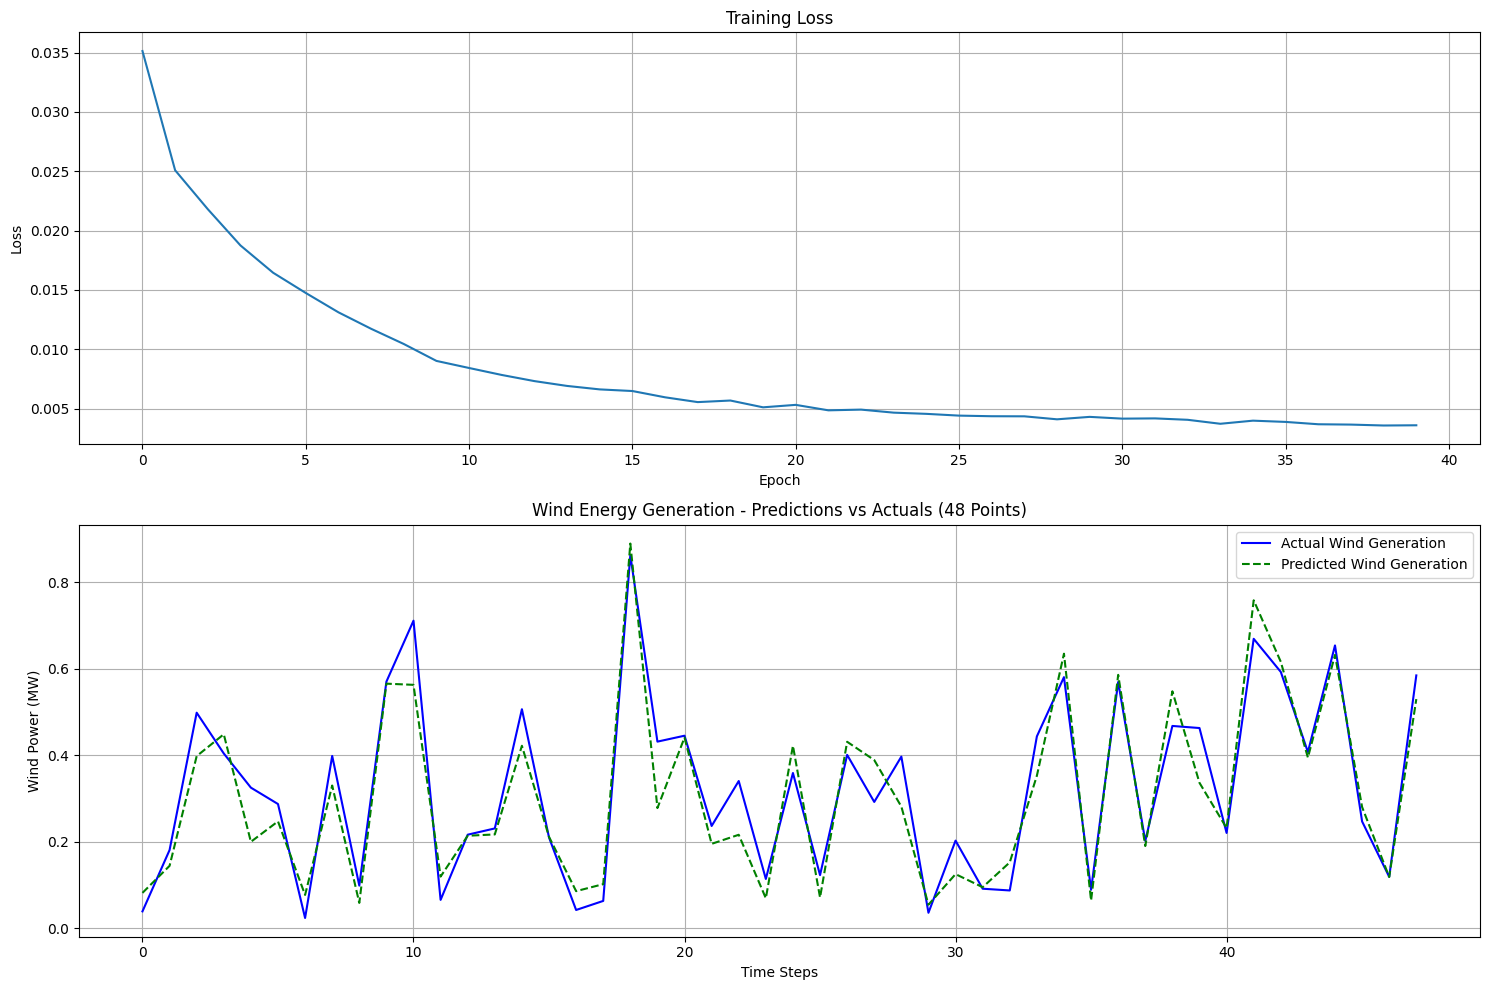

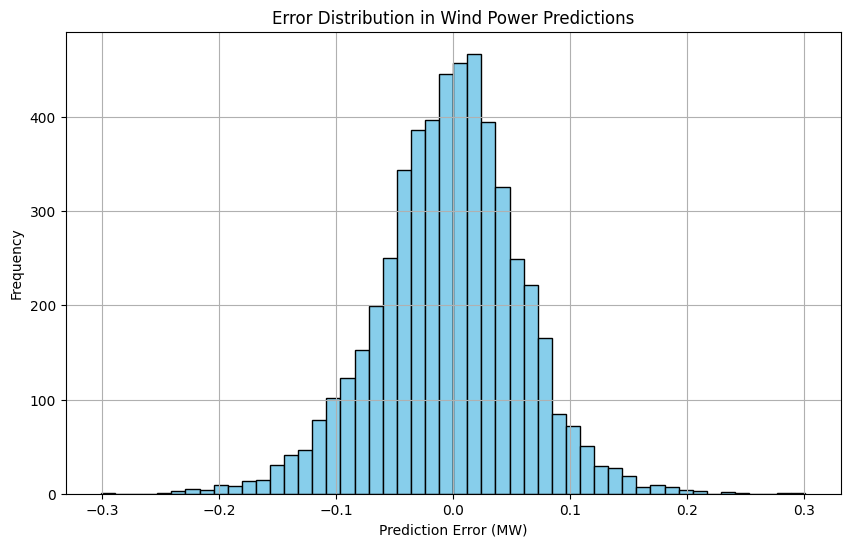


Wind Generation Forecasting Metrics (computed on full test set):
Mean Absolute Error: 0.05 MW
Root Mean Square Error: 0.06 MW
R² Score: 0.9287

Additional Statistics (computed on full test set):
Mean Error: -0.00 MW
Error Standard Deviation: 0.06 MW
90th Percentile of Absolute Error: 0.10 MW


In [21]:
# Cell 6: Main Execution
# Hyperparameters optimized for wind forecasting
BATCH_SIZE = 32  # Smaller batch size for better generalization
SEQUENCE_LENGTH = 36  # Longer sequence for wind patterns
NUM_EPOCHS = 40  # More epochs for complex patterns
LEARNING_RATE = 0.0003  # Lower learning rate for stability

# Create dataset
dataset = WindDataset(features_scaled, targets_scaled, SEQUENCE_LENGTH)

# Split data
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
input_channels = features_scaled.shape[1]
model = WindCNN(input_channels, SEQUENCE_LENGTH).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train model
losses = train_wind_model(model, train_loader, criterion, optimizer, device, NUM_EPOCHS)

# Evaluate model (get all predictions first)
model.eval()
all_predictions = []
all_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_predictions.extend(outputs.cpu().numpy())
        all_actuals.extend(batch_y.numpy())

# Convert to arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Calculate metrics using all data
mae = mean_absolute_error(all_actuals, all_predictions)
rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
r2 = r2_score(all_actuals, all_predictions)

# Calculate errors on full dataset
errors = all_predictions - all_actuals

# Plot results
plt.figure(figsize=(15, 10))

# Training loss
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Loss', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Predictions vs Actuals (only first 48 samples for visualization)
plt.subplot(2, 1, 2)
plt.plot(all_actuals[:48], label='Actual Wind Generation', color='blue')
plt.plot(all_predictions[:48], label='Predicted Wind Generation', color='green', linestyle='--')
plt.title('Wind Energy Generation - Predictions vs Actuals (48 Points)', fontsize=12)
plt.xlabel('Time Steps')
plt.ylabel('Wind Power (MW)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional error distribution plot (using all data)
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.title('Error Distribution in Wind Power Predictions', fontsize=12)
plt.xlabel('Prediction Error (MW)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print metrics
print("\nWind Generation Forecasting Metrics (computed on full test set):")
print(f"Mean Absolute Error: {mae:.2f} MW")
print(f"Root Mean Square Error: {rmse:.2f} MW")
print(f"R² Score: {r2:.4f}")

# Calculate and print additional statistics
print("\nAdditional Statistics (computed on full test set):")
print(f"Mean Error: {np.mean(errors):.2f} MW")
print(f"Error Standard Deviation: {np.std(errors):.2f} MW")
print(f"90th Percentile of Absolute Error: {np.percentile(np.abs(errors), 90):.2f} MW")

# Save model if needed
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler_features': scaler_features,
    'scaler_target': scaler_target,
    'sequence_length': SEQUENCE_LENGTH,
    'input_channels': input_channels
}, 'wind_forecasting_model.pth')